In [59]:
%matplotlib notebook
import numpy as np
import os
import xmltodict
import glob
import cv2
from tqdm import tqdm
import tensorflow._api.v2.compat.v1 as tf
from psbody.mesh import Mesh
from skimage import io
import time
from matplotlib import pyplot as plt


In [6]:
# List of face images that we want to visualize
base_seq = "/home/oole/Data/Chokepoint/face_data/G1/train/P1E_S1/P1E_S1_C1_seq_1"
image_names = ["00000240.jpg", "00000241.jpg", "00000242.jpg", "00000243.jpg", "00000244.jpg"]
image_paths = [os.path.join(base_seq, img) for img in image_names]

In [9]:
# Ringnet preprocess:
def resize_img(img, scale_factor):
    new_size = (np.floor(np.array(img.shape[0:2]) * scale_factor)).astype(int)
    new_img = cv2.resize(img, (new_size[1], new_size[0]))
    # This is scale factor of [height, width] i.e. [y, x]
    actual_factor = [
        new_size[0] / float(img.shape[0]), new_size[1] / float(img.shape[1])
    ]
    return new_img, actual_factor

def scale_and_crop(image, scale, center, img_size):
    image_scaled, scale_factors = resize_img(image, scale)
    # Swap so it's [x, y]
    scale_factors = [scale_factors[1], scale_factors[0]]
    center_scaled = np.round(center * scale_factors).astype(np.int)

    margin = int(img_size / 2)
    image_pad = np.pad(
        image_scaled, ((margin, ), (margin, ), (0, )), mode='edge')
    center_pad = center_scaled + margin
    # figure out starting point
    start_pt = center_pad - margin
    end_pt = center_pad + margin
    # crop:
    crop = image_pad[start_pt[1]:end_pt[1], start_pt[0]:end_pt[0], :]
    proc_param = {
        'scale': scale,
        'start_pt': start_pt,
        'end_pt': end_pt,
        'img_size': img_size
    }

    return crop, proc_param

def preprocess_image(img_path):
    img = io.imread(img_path)
    if np.max(img.shape[:2]) != 224:
        print('Resizing so the max image size is %d..' % 224)
        scale = (float(224) / np.max(img.shape[:2]))
    else:
        scale = 1.0#scaling_factor
    center = np.round(np.array(img.shape[:2]) / 2).astype(int)
    # image center in (x,y)
    center = center[::-1]
    crop, proc_param = scale_and_crop(img, scale, center,
                                               224)
    # import ipdb; ipdb.set_trace()
    # Normalize image to [-1, 1]
    # plt.imshow(crop/255.0)
    # plt.show()
    crop = 2 * ((crop / 255.) - 0.5)

    return crop, proc_param, img

In [25]:
# Load and read ringnet
# viewer = MeshViewer()
template_mesh = Mesh(filename="/home/oole/git/ma/coma/impl/data/template.obj")

load_path = "/mnt/storage/Msc/RingNet/model/ring_6_68641"
model_path = load_path + ".meta"

predicted_meshes = {}
with tf.Session() as sess:
    graph = sess.graph
    saver = tf.compat.v1.train.import_meta_graph(model_path)
    saver.restore(sess, load_path)
    vertices = graph.get_tensor_by_name(u'Flamenetnormal_2/Add_9:0')
    params = graph.get_tensor_by_name(u'add_2:0')
    image_input = graph.get_tensor_by_name(u'input_images:0')
    
    i = 0
    for img_path in tqdm(image_paths):
        crop, proc_param, img = preprocess_image(img_path)
        face_image = np.expand_dims(crop, axis=0)
        # input_image = np.expand_dims(face_image, axis=0)
        fetch_dict = {'vertices': vertices,
                     'parameters': params}
        feed_dict = {
                image_input: face_image
            }
        
        res = sess.run(fetch_dict, feed_dict)
        verts = res['vertices'][0]
        parameters = res['parameters'][0]
        predicted_meshes[os.path.basename(img_path)] = {
            'crop': crop,
            'proc_param': proc_param,
            'img': img,
            'verts': verts,
            'parameters': parameters
        }

INFO:tensorflow:Restoring parameters from /mnt/storage/Msc/RingNet/model/ring_6_68641


100%|██████████| 5/5 [00:00<00:00,  8.37it/s]


In [70]:
# save dict
import pickle
# np.save("/home/oole/camera_dict.npy", predicted_meshes)
# pickle.dump("/home/oole/camera_dict.npy")
pickle.dump(predicted_meshes, open("/home/oole/camera_dict.pickle", 'wb'), protocol=2)

In [54]:
from opendr.camera import ProjectPoints
from opendr.renderer import ColoredRenderer
from opendr.lighting import LambertianPointLight


colors = {
    # colorbline/print/copy safe:
    'light_blue': [0.65098039, 0.74117647, 0.85882353],
    'light_pink': [.9, .7, .7],  # This is used to do no-3d
}


class SMPLRenderer(object):
    def __init__(self,
                 img_size=256,
                 flength=500.,
                 faces=None):
        self.faces = faces
        self.w = img_size
        self.h = img_size
        self.flength = flength

    def __call__(self,
                 verts,
                 cam=None,
                 img=None,
                 do_alpha=False,
                 far=None,
                 near=None,
                 color_id=0,
                 img_size=None):
        """
        cam is 3D [f, px, py]
        """
        if img is not None:
            h, w = img.shape[:2]
        elif img_size is not None:
            h = img_size[0]
            w = img_size[1]
        else:
            h = self.h
            w = self.w

        if cam is None:
            cam = [self.flength, w / 2., h / 2.]

        use_cam = ProjectPoints(
            f=cam[0] * np.ones(2),
            rt=np.zeros(3),
            t=np.zeros(3),
            k=np.zeros(5),
            c=cam[1:3])

        if near is None:
            near = np.maximum(np.min(verts[:, 2]) - 25, 0.1)
        if far is None:
            far = np.maximum(np.max(verts[:, 2]) + 25, 25)

        imtmp = render_model(
            verts,
            self.faces,
            w,
            h,
            use_cam,
            do_alpha=do_alpha,
            img=img,
            far=far,
            near=near,
            color_id=color_id)

        return (imtmp * 255).astype('uint8')

    def rotated(self,
                verts,
                deg,
                cam=None,
                axis='y',
                img=None,
                do_alpha=True,
                far=None,
                near=None,
                color_id=0,
                img_size=None):
        import math
        if axis == 'y':
            around = cv2.Rodrigues(np.array([0, math.radians(deg), 0]))[0]
        elif axis == 'x':
            around = cv2.Rodrigues(np.array([math.radians(deg), 0, 0]))[0]
        else:
            around = cv2.Rodrigues(np.array([0, 0, math.radians(deg)]))[0]
        center = verts.mean(axis=0)
        new_v = np.dot((verts - center), around) + center

        return self.__call__(
            new_v,
            cam,
            img=img,
            do_alpha=do_alpha,
            far=far,
            near=near,
            img_size=img_size,
            color_id=color_id)
    
def get_alpha(imtmp, bgval=1.):
    h, w = imtmp.shape[:2]
    alpha = (~np.all(imtmp == bgval, axis=2)).astype(imtmp.dtype)

    b_channel, g_channel, r_channel = cv2.split(imtmp)

    im_RGBA = cv2.merge((b_channel, g_channel, r_channel, alpha.astype(
        imtmp.dtype)))
    return im_RGBA

def simple_renderer(rn,
                    verts,
                    faces,
                    yrot=np.radians(120),
                    color=colors['light_pink']):
    # Rendered model color
    rn.set(v=verts, f=faces, vc=color, bgcolor=np.ones(3))
    albedo = rn.vc

    # Construct Back Light (on back right corner)
    rn.vc = LambertianPointLight(
        f=rn.f,
        v=rn.v,
        num_verts=len(rn.v),
        light_pos=_rotateY(np.array([-200, -100, -100]), yrot),
        vc=albedo,
        light_color=np.array([1, 1, 1]))

    # Construct Left Light
    rn.vc += LambertianPointLight(
        f=rn.f,
        v=rn.v,
        num_verts=len(rn.v),
        light_pos=_rotateY(np.array([800, 10, 300]), yrot),
        vc=albedo,
        light_color=np.array([1, 1, 1]))

    # Construct Right Light
    rn.vc += LambertianPointLight(
        f=rn.f,
        v=rn.v,
        num_verts=len(rn.v),
        light_pos=_rotateY(np.array([-500, 500, 1000]), yrot),
        vc=albedo,
        light_color=np.array([.7, .7, .7]))

    return rn.r

    
def render_model(verts,
                 faces,
                 w,
                 h,
                 cam,
                 near=0.5,
                 far=25,
                 img=None,
                 do_alpha=False,
                 color_id=None):
    rn = _create_renderer(
        w=w, h=h, near=near, far=far, rt=cam.rt, t=cam.t, f=cam.f, c=cam.c)

    # Uses img as background, otherwise white background.
    if img is not None:
        rn.background_image = img / 255. if img.max() > 1 else img

    
    if color_id is None:
        color = colors['light_blue']
    else:
        color_list = colors.values()
        print("color_list : {}".format(color_list))
        #color = color_list[color_id % len(color_list)]
        color = colors['light_pink']

    imtmp = simple_renderer(rn, verts, faces, color=color)

    # If white bg, make transparent.
    if img is None and do_alpha:
        imtmp = get_alpha(imtmp)
    elif img is not None and do_alpha:
        imtmp = append_alpha(imtmp)

    return imtmp

def append_alpha(imtmp):
    alpha = np.ones_like(imtmp[:, :, 0]).astype(imtmp.dtype)
    if np.issubdtype(imtmp.dtype, np.uint8):
        alpha = alpha * 255
    b_channel, g_channel, r_channel = cv2.split(imtmp)
    im_RGBA = cv2.merge((b_channel, g_channel, r_channel, alpha))
    return im_RGBA

def _rotateY(points, angle):
    """Rotate the points by a specified angle."""
    ry = np.array([[np.cos(angle), 0., np.sin(angle)], [0., 1., 0.],
                   [-np.sin(angle), 0., np.cos(angle)]])
    return np.dot(points, ry)


def _create_renderer(w=640,
                     h=480,
                     rt=np.zeros(3),
                     t=np.zeros(3),
                     f=None,
                     c=None,
                     k=None,
                     near=.5,
                     far=10.):

    f = np.array([w, w]) / 2. if f is None else f
    c = np.array([w, h]) / 2. if c is None else c
    k = np.zeros(5) if k is None else k

    rn = ColoredRenderer()

    rn.camera = ProjectPoints(rt=rt, t=t, f=f, c=c, k=k)
    rn.frustum = {'near': near, 'far': far, 'height': h, 'width': w}
    return rn

    
def get_original(proc_param, verts, cam, img_size):
    img_size = proc_param['img_size']
    undo_scale = 1. / np.array(proc_param['scale'])

    cam_s = cam[0]
    cam_pos = cam[1:]
    principal_pt = np.array([img_size, img_size]) / 2.
    flength = 50000.0 #500.
    tz = flength / (0.5 * img_size * cam_s)
    trans = np.hstack([cam_pos, tz])
    vert_shifted = verts + trans

    start_pt = proc_param['start_pt'] - 0.5 * img_size
    final_principal_pt = (principal_pt + start_pt) * undo_scale
    cam_for_render = np.hstack(
        [np.mean(flength * undo_scale), final_principal_pt])

    # This is in padded image.
    # kp_original = (joints + proc_param['start_pt']) * undo_scale
    # Subtract padding from joints.
    margin = int(img_size / 2)
    # kp_original = (joints + proc_param['start_pt'] - margin) * undo_scale

    return cam_for_render, vert_shifted, #kp_original

color_list : dict_values([[0.65098039, 0.74117647, 0.85882353], [0.9, 0.7, 0.7]])
color_list : dict_values([[0.65098039, 0.74117647, 0.85882353], [0.9, 0.7, 0.7]])
(5023, 3)


<IPython.core.display.Javascript object>


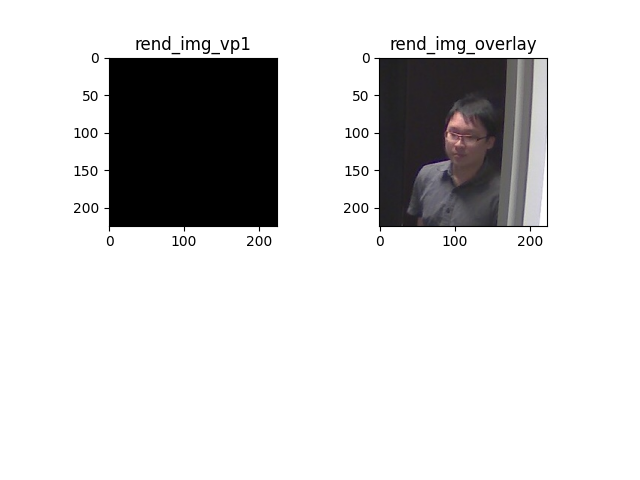

In [62]:
renderer = SMPLRenderer(faces=template_mesh.f)

for mesh_set in predicted_meshes:
    entry = predicted_meshes[mesh_set]
    latent_parameters = entry['parameters']
    cam_parameters = latent_parameters[:3]
    cam_for_render, verts_shifted = get_original(entry['proc_param'], entry['verts'], cam_parameters, [224,224])
    rend_img_overlay = renderer(verts_shifted*1.0, cam=cam_for_render, img=entry['img'], do_alpha=True)
    rend_img_vp1 = renderer.rotated(
        verts_shifted, 30, cam=cam_for_render, img_size=[224,224])
    print(verts_shifted.shape)
    fig = plt.figure(1)
    plt.subplot(221)
    plt.imshow(rend_img_vp1)
    plt.title("rend_img_vp1")
    plt.subplot(222)
    plt.imshow(rend_img_overlay)
    plt.title("rend_img_overlay")
    plt.show()
    break